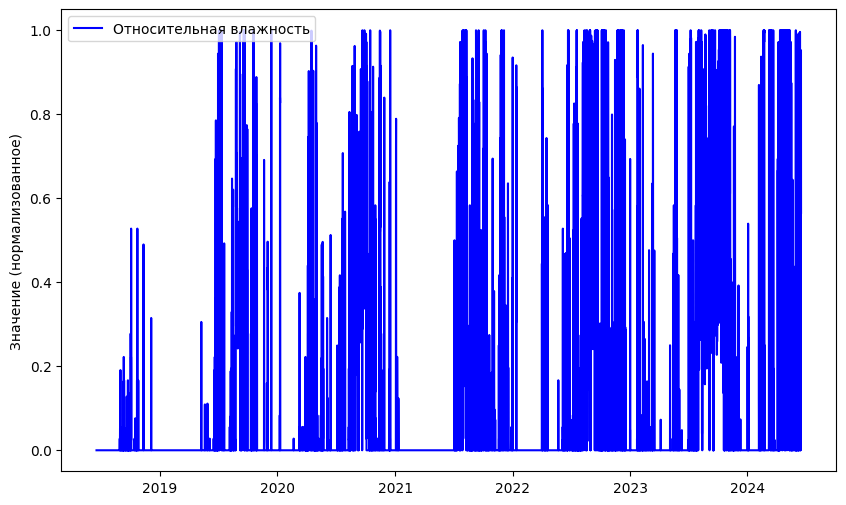

(13140, 56, 7) (13140,) (2190, 56, 7) (2190,) (2135, 56, 7) (2135,)


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Загрузка данных
df = pd.read_csv("../meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

# Включение необходимых колонок
required_cols = ['HC_RELATIVE_HUMIDITY', 'DEW_POINT', 'LEAF_WETNESS', 'PRECIPITATION', 'HC_AIR_TEMPERATURE', 'WIND_SPEED', 'SOLAR_RADIATION']
df = df[required_cols]
df = df.resample('3h').mean()

# Нормализация данных
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Визуализация данных
plt.figure(figsize=(10, 6))
plt.plot(scaled_df['HC_RELATIVE_HUMIDITY'], label='Относительная влажность', color='blue')
plt.ylabel('Значение (нормализованное)')
plt.legend()
plt.show()

# Функция для преобразования данных в X и y
def df_to_X_y(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i + window_size])
        y.append(df_as_np[i + window_size][0])
    return np.array(X), np.array(y)

WINDOW_SIZE = 56
X, y = df_to_X_y(scaled_df, WINDOW_SIZE)

# Разделение данных на обучающую, валидационную и тестовую выборки
n = len(scaled_df)
train_size = int(n * 0.75)
val_size = int(n * 0.125)
test_size = n - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

In [3]:
# Определение модели
model = Sequential()
model.add(InputLayer((WINDOW_SIZE, len(required_cols))))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

# Настройки обратного вызова и компиляции модели
model_save_path = 'model2/model2-HC_RELATIVE_HUMIDITY.keras'
cp = ModelCheckpoint(model_save_path, save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 56, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 56, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,545 (252.13 KB)

 Trainable params: 64,545 (252.13 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Обучение модели
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

# Сохранение модели
model_save_path = 'model2/model2-HC_RELATIVE_HUMIDITY.keras'
model.save(model_save_path)
print(f"Модель сохранена в {model_save_path}")

Epoch 1/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 44s 87ms/step - loss: 0.0393 - root_mean_squared_error: 0.1975 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1929
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step - loss: 0.0278 - root_mean_squared_error: 0.1666 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1888
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - loss: 0.0260 - root_mean_squared_error: 0.1613 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1894
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - loss: 0.0262 - root_mean_squared_error: 0.1617 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1874
Epoch 5/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1830
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - loss: 0.0239 - root_mean_squared_error: 0.1546 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1810
Epoch 7/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 

In [5]:
# Загрузка модели
model = tf.keras.models.load_model(model_save_path)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Обратная трансформация предсказанных данных
y_test_inverse = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), len(required_cols) - 1))], axis=1))[:, 0]
y_pred_inverse = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), len(required_cols) - 1))], axis=1))[:, 0]

# Вывод предсказаний
print(y_pred_inverse)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step
[49.37405884 55.7431519  58.24353099 ... 61.40836477 66.55141115
 51.36893988]


In [6]:
# Прогнозирование на будущее
def predict_future(model, last_known_data, last_known_dates, steps=3, window_size=56):
    predictions = []
    future_dates = pd.date_range(start=last_known_dates[-1], periods=steps + 1, freq='3h')[1:]
    
    current_data = last_known_data.tolist()
    
    for _ in range(steps):
        input_data = np.array(current_data[-window_size:]).reshape(1, window_size, len(required_cols))
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        current_data.append([prediction[0, 0]] + [0] * (len(required_cols) - 1))  # Добавляем 0 для остальных признаков
    
    return future_dates, predictions

# Последние известные данные и даты
last_known_data = scaled_df.values[-WINDOW_SIZE:]
last_known_dates = scaled_df.index[-WINDOW_SIZE:]

# Прогнозирование на 56 шагов вперед
future_steps = 56
future_dates, predictions = predict_future(model, last_known_data, last_known_dates, future_steps, WINDOW_SIZE)

# Обратная трансформация предсказанных данных для будущего
predictions_inverse = scaler.inverse_transform(np.concatenate([np.array(predictions).reshape(-1, 1), np.zeros((len(predictions), len(required_cols) - 1))], axis=1))[:, 0]

# Вывод предсказаний с датами
for date, pred in zip(future_dates, predictions_inverse):
    print(f"{date}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/ste

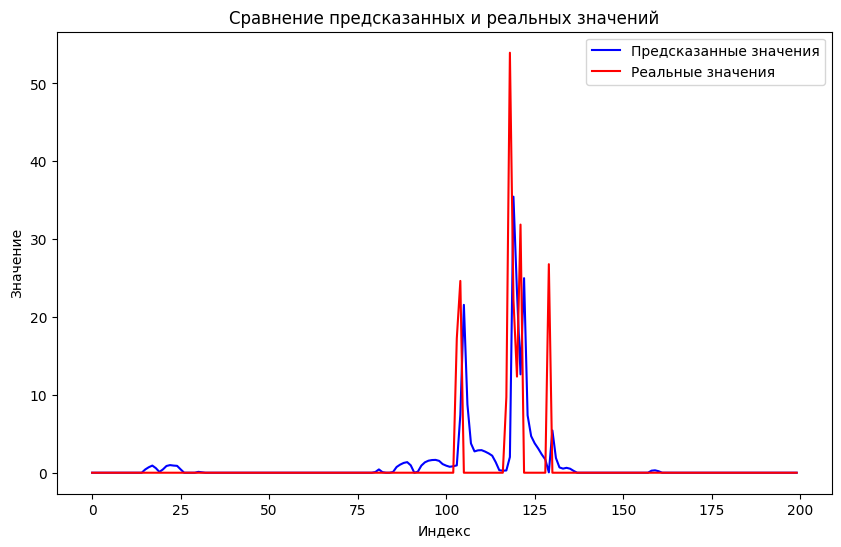

Средняя абсолютная ошибка (MAE): 11.009752969963676
Средняя квадратичная ошибка (MSE): 384.35275105124464
Корень из среднеквадратичной ошибки (RMSE): 19.604916502021748
Коэффициент детерминации (R^2): 0.7072426265863218


In [7]:
# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred_inverse[700:900], label='Предсказанные значения', color='blue')
plt.plot(y_test_inverse[700:900], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Оценка модели
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)